In [1]:
!mkdir -p /content/drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [4]:
DIRECTORY = r"/content/drive/MyDrive/Bin /Data_Project/Data Mask-wear-detector/DataProject/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [5]:
data = []
labels = []


In [6]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [10]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 1s 0us/step


In [13]:
head_model = baseModel.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

In [15]:
model = Model(inputs=baseModel.input, outputs=head_model)

In [16]:
for layer in baseModel.layers:
	layer.trainable = False

In [22]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [25]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [26]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[early_stopping])

Epoch 1/20
95/95 [==============================] - 39s 381ms/step - loss: 0.0381 - accuracy: 0.9881 - val_loss: 0.0266 - val_accuracy: 0.9857
Epoch 2/20
95/95 [==============================] - 34s 360ms/step - loss: 0.0353 - accuracy: 0.9871 - val_loss: 0.0305 - val_accuracy: 0.9844
Epoch 3/20
95/95 [==============================] - 34s 357ms/step - loss: 0.0284 - accuracy: 0.9911 - val_loss: 0.0182 - val_accuracy: 0.9935
Epoch 4/20
95/95 [==============================] - 35s 367ms/step - loss: 0.0252 - accuracy: 0.9934 - val_loss: 0.0459 - val_accuracy: 0.9817
Epoch 5/20
95/95 [==============================] - 34s 355ms/step - loss: 0.0243 - accuracy: 0.9914 - val_loss: 0.0297 - val_accuracy: 0.9883
Epoch 6/20
95/95 [==============================] - 35s 364ms/step - loss: 0.0298 - accuracy: 0.9891 - val_loss: 0.0225 - val_accuracy: 0.9896


In [27]:
predIdxs = model.predict(testX, batch_size=BS)

24/24 [==============================] - 3s 67ms/step


In [28]:
predIdxs = np.argmax(predIdxs, axis=1)

In [29]:
model.save("/content/drive/MyDrive/Bin /Project/mask_detector.model", save_format="h5")

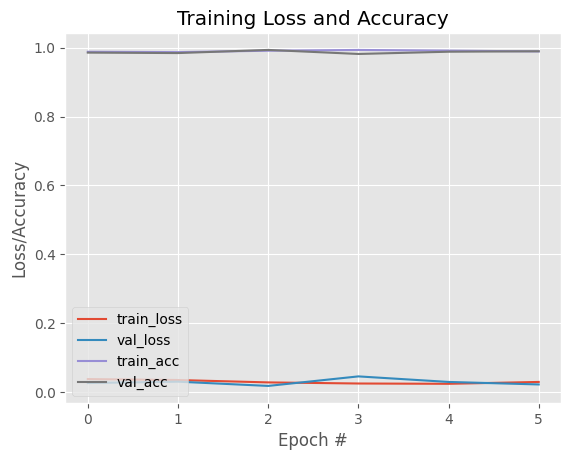

In [31]:
N = len(H.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


In [32]:
Model = tf.keras.models.load_model("/content/drive/MyDrive/Bin /Project/mask_detector.model")

In [33]:
Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             